In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.abspath(".."))
from src.data_setup import load_data, split_cities
from src.pipeline import create_pipeline
from src.inference import create_diff_target, predict_on_test, predict_on_test_normal
from src.visualization import visualize_predictions

In [2]:
features_train, target_train = load_data(train=True)
sj_features_train, iq_features_train = split_cities(features_train)
sj_target_train, iq_target_train = split_cities(target_train)

features_test, _ = load_data(train=False)
sj_features_test, iq_features_test = split_cities(features_test)

In [3]:
cases_values = sj_target_train.reset_index()["total_cases"].values

In [4]:
sj_diff_target, sj_target_merged = create_diff_target(sj_target_train)
iq_diff_target, iq_target_merged = create_diff_target(iq_target_train)

In [5]:
aggregation_periods = [1, 2, 3, 4]
cols_to_aggregate = ['precipitation_amt_mm',
                      'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_precip_amt_kg_per_m2',
                      'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm']
k_prev = 10

sj_train_pipeline = create_pipeline(aggregation_periods=aggregation_periods,
                                 cols_to_aggregate=cols_to_aggregate,
                                 date_column="week_start_date",
                                 k_prev=k_prev,
                                 test=False)

sj_test_pipeline = create_pipeline(aggregation_periods=aggregation_periods,
                                 cols_to_aggregate=cols_to_aggregate,
                                 date_column="week_start_date",
                                 k_prev=k_prev,
                                 test=True)

iq_train_pipeline = create_pipeline(aggregation_periods=aggregation_periods,
                                 cols_to_aggregate=cols_to_aggregate,
                                 date_column="week_start_date",
                                 k_prev=k_prev,
                                 test=False)

iq_test_pipeline = create_pipeline(aggregation_periods=aggregation_periods,
                                 cols_to_aggregate=cols_to_aggregate,
                                 date_column="week_start_date",
                                 k_prev=k_prev,
                                 test=True)

In [6]:
sj_features_train_transformed = sj_train_pipeline.fit_transform(sj_features_train, sj_target_train)
iq_features_train_transformed = iq_train_pipeline.fit_transform(iq_features_train, iq_target_train)

In [7]:
sj_test_pipeline.fit(sj_features_train, sj_target_train)
iq_test_pipeline.fit(iq_features_train, iq_target_train)

Pipeline(steps=[('data_handler', DateHandler(date_column='week_start_date')),
                ('imputer', NAImputer()),
                ('weather_aggregator',
                 WeatherAggregator(cols_to_aggregate=['precipitation_amt_mm',
                                                      'reanalysis_air_temp_k',
                                                      'reanalysis_avg_temp_k',
                                                      'reanalysis_precip_amt_kg_per_m2',
                                                      'reanalysis_relative_humidity_percent',
                                                      'reanalysis_sat_precip_amt_mm',
                                                      'station_precip_mm'],
                                   periods=[1, 2, 3, 4])),
                ('k_prev_adder', PrevCasesAdder(k_prev=10)),
                ('outbreak_adder', OutbreakAdder()),
                ['update_test', PrevCasesTestUpdater(k_prev=10)]])

In [8]:
sj_features_test_transformed = sj_test_pipeline.transform(sj_features_test)
iq_features_test_transformed = iq_test_pipeline.transform(iq_features_test)

/Users/gasparsekula/anaconda3/envs/automl/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/gasparsekula/anaconda3/envs/automl/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


# Training

In [10]:
PARAM_GRID_RF = {
    'n_estimators': [500, 800],
    'max_depth': [1, 10, 20, 30],
    'min_samples_split': [2, 10, 15, 20, 30],
    'min_samples_leaf': [1, 5, 10, 20, 30]
}

model = RandomForestRegressor()

In [11]:
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=PARAM_GRID_RF, 
                                   n_iter=50, 
                                   scoring='neg_mean_absolute_error', 
                                   cv=5,  
                                   random_state=42, 
                                   n_jobs=-1,
                                   verbose=0)

In [13]:
random_search.fit(sj_features_train_transformed, sj_target_train.values.squeeze())

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 10, 20, 30],
                                        'min_samples_leaf': [1, 5, 10, 20, 30],
                                        'min_samples_split': [2, 10, 15, 20,
                                                              30],
                                        'n_estimators': [500, 800]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [14]:
sj_model = random_search.best_estimator_

In [19]:
joblib.dump(sj_model, "../models/rfr_sj_normal.pkl")

['../models/rfr_sj_normal.pkl']

In [15]:
random_search.fit(iq_features_train_transformed, iq_target_train.values.squeeze())

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 10, 20, 30],
                                        'min_samples_leaf': [1, 5, 10, 20, 30],
                                        'min_samples_split': [2, 10, 15, 20,
                                                              30],
                                        'n_estimators': [500, 800]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [16]:
iq_model = random_search.best_estimator_

In [20]:
joblib.dump(iq_model, "../models/rfr_iq_normal.pkl")

['../models/rfr_iq_normal.pkl']

# Predicting target

In [7]:
sj_model = joblib.load("../models/rfr_sj_normal.pkl")
iq_model = joblib.load("../models/rfr_iq_normal.pkl")

In [40]:
sj_test_predictions = np.maximum(predict_on_test_normal(sj_features_test_transformed, sj_model), 0)
iq_test_predictions = np.maximum(predict_on_test_normal(iq_features_test_transformed, iq_model), 0)

In [41]:
sj_test_predictions_series = pd.Series(sj_test_predictions, index=sj_features_test.index)
iq_test_predictions_series = pd.Series(iq_test_predictions, index=iq_features_test.index)

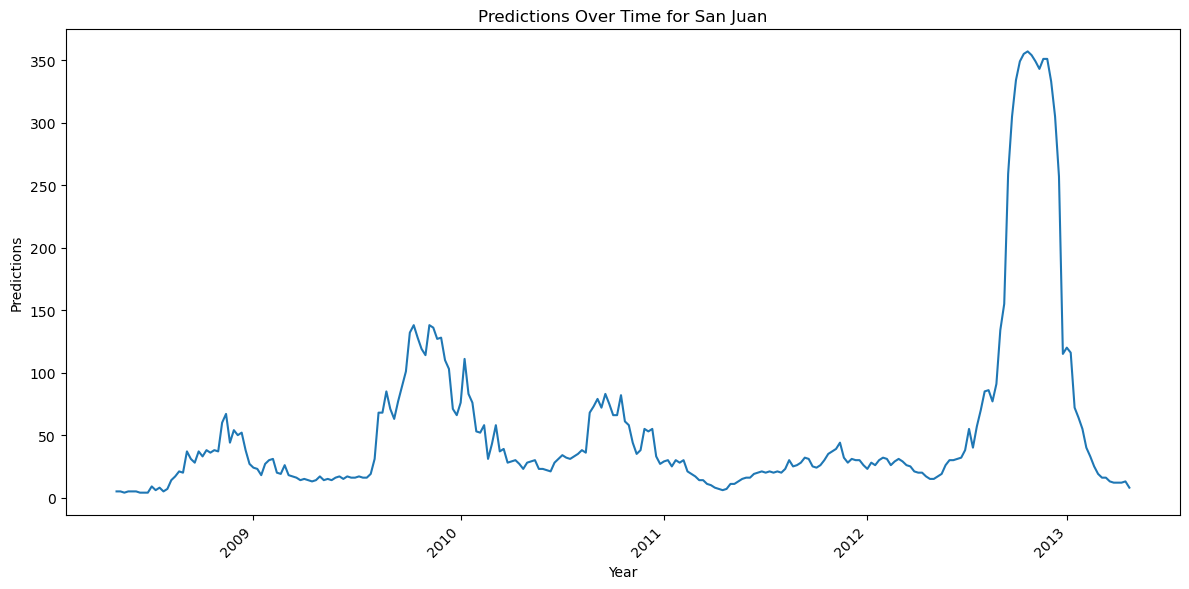

In [42]:
visualize_predictions(sj_test_predictions_series, "sj")

In [43]:
# Extract indices for the second half of 2010 and 2011
second_half_2010 = sj_test_predictions_series[(sj_test_predictions_series.index.get_level_values('year') == 2009) & 
                                              (sj_test_predictions_series.index.get_level_values('weekofyear') >= 26)]
second_half_2011 = sj_test_predictions_series[(sj_test_predictions_series.index.get_level_values('year') == 2010) & 
                                              (sj_test_predictions_series.index.get_level_values('weekofyear') >= 26)]

# Swap the predictions
sj_test_predictions_series.loc[second_half_2010.index] = second_half_2011.values - 20
sj_test_predictions_series.loc[second_half_2011.index] = second_half_2010.values * 2

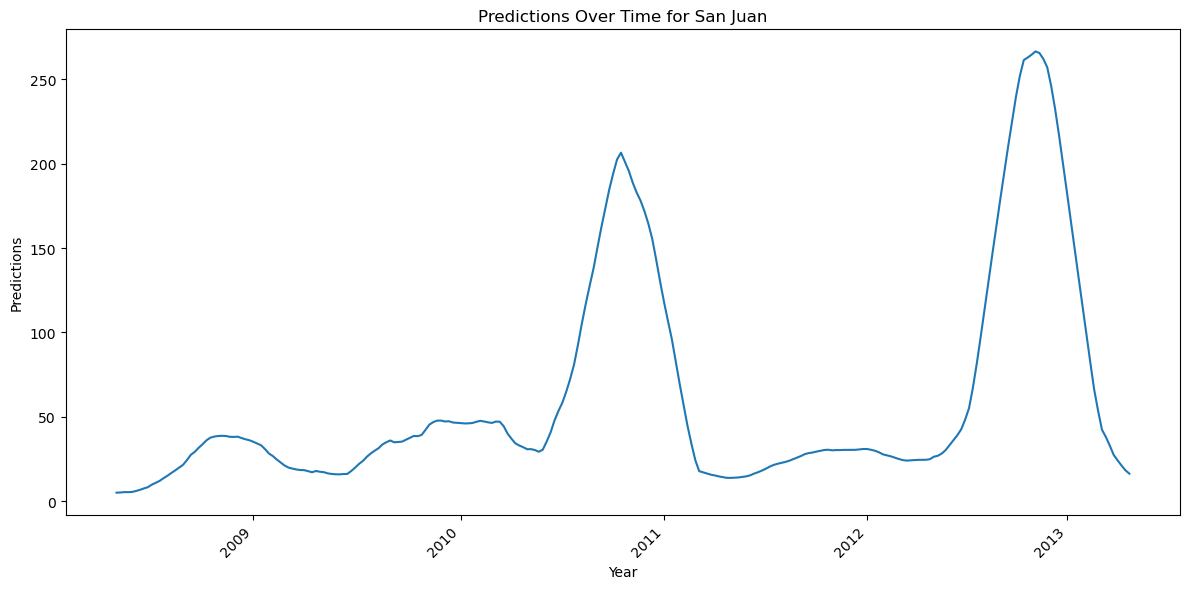

In [44]:
sj_test_predictions_series_ma = sj_test_predictions_series.rolling(window=20, center=True, min_periods=1).mean()

visualize_predictions(sj_test_predictions_series_ma, "sj")

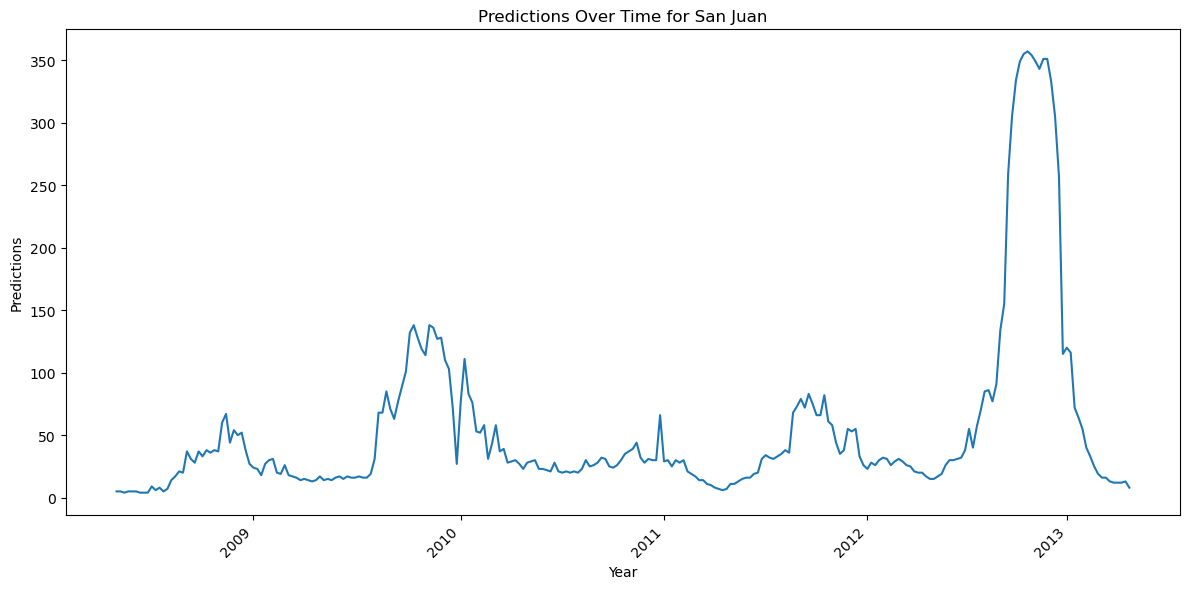

In [32]:
visualize_predictions(sj_test_predictions_series, "sj")

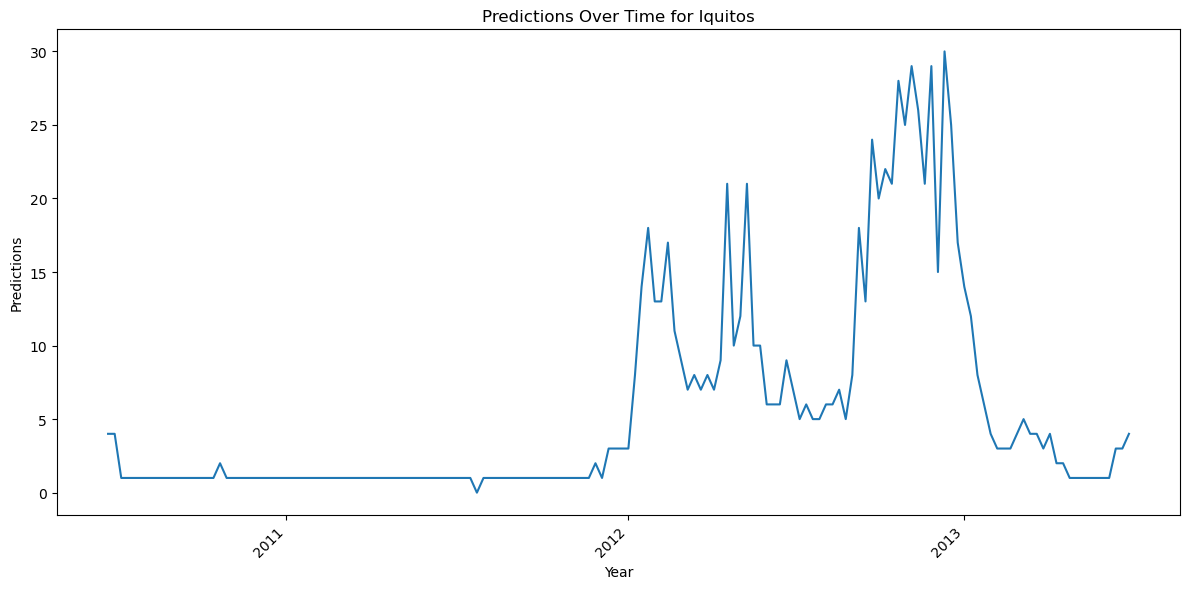

In [21]:
visualize_predictions(iq_test_predictions_series, "iq")

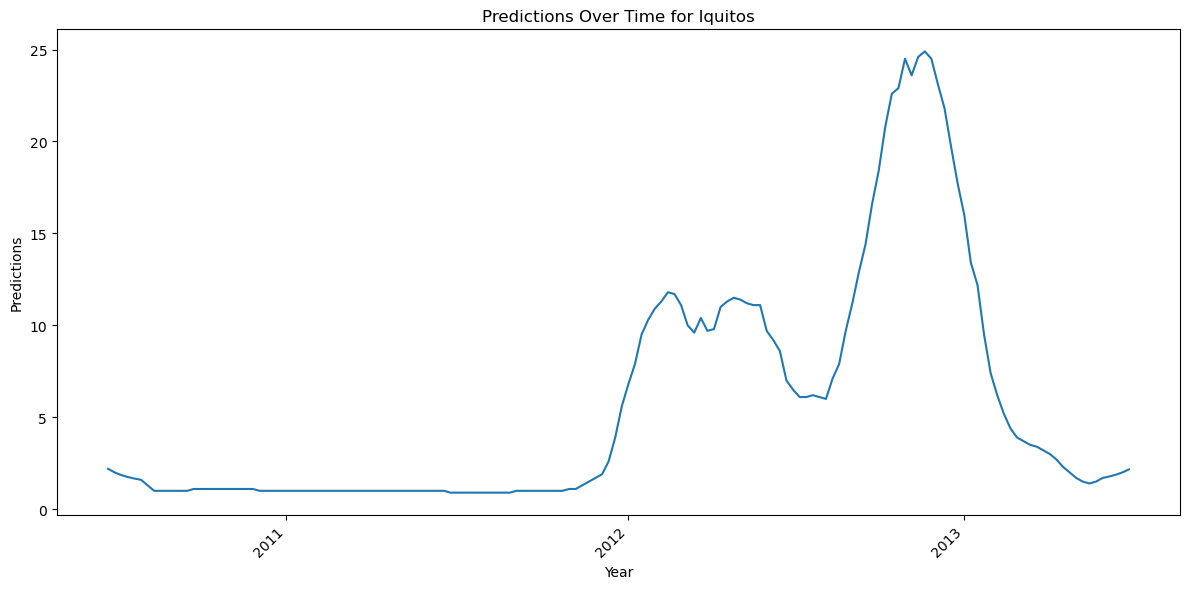

In [53]:
iq_test_predictions_series_ma = iq_test_predictions_series.rolling(window=10, min_periods=1, center=True).mean()

visualize_predictions(iq_test_predictions_series_ma, city='iq')

# Predicting difference from mean

In [7]:
sj_model = joblib.load("../models/rfr_sj_diff.pkl")
iq_model = joblib.load("../models/rfr_iq_diff.pkl")

In [8]:
sj_test_predictions = np.maximum(predict_on_test(sj_features_test_transformed, sj_target_train, sj_model), 0)
iq_test_predictions = np.maximum(predict_on_test(iq_features_test_transformed, iq_target_train, iq_model), 0)

In [9]:
sj_test_predictions_series = pd.Series(sj_test_predictions, index=sj_features_test.index)
iq_test_predictions_series = pd.Series(iq_test_predictions, index=iq_features_test.index)

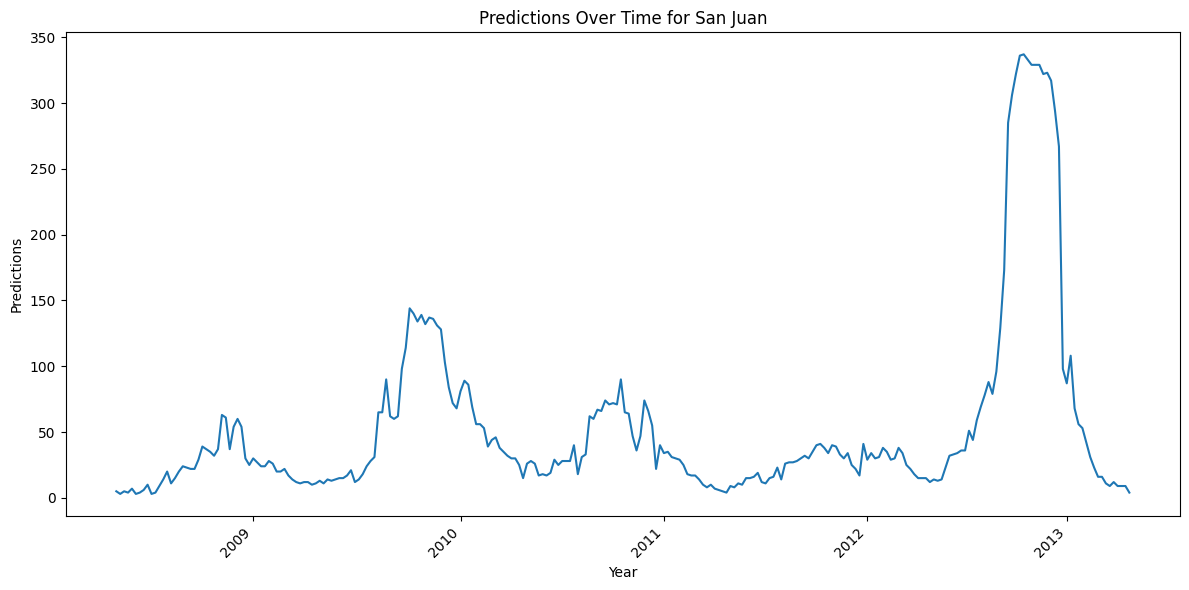

In [12]:
visualize_predictions(sj_test_predictions_series, "sj")

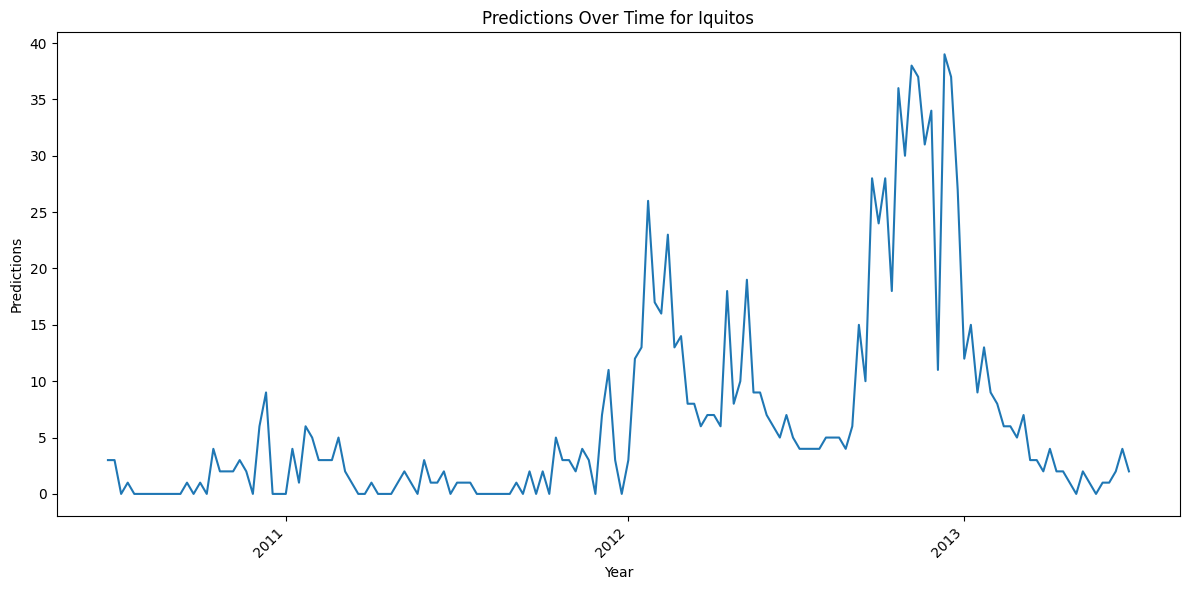

In [13]:
visualize_predictions(iq_test_predictions_series, "iq")

In [64]:
iq_np = iq_test_predictions_series_ma.values + 10
quantile_75 = np.quantile(iq_np, 0.93)
iq_np = np.where(iq_np > quantile_75, iq_np * 2, iq_np)
iq_np = iq_np[::-1].round().astype(int)
iq_np

array([12, 12, 12, 12, 12, 12, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14,
       14, 14, 15, 16, 17, 20, 22, 23, 26, 28, 59, 64, 66, 69, 70, 69, 67,
       69, 66, 65, 62, 28, 27, 24, 23, 21, 20, 18, 17, 16, 16, 16, 16, 16,
       16, 17, 19, 19, 20, 21, 21, 21, 21, 22, 21, 21, 20, 20, 20, 20, 20,
       21, 22, 22, 21, 21, 20, 20, 18, 17, 16, 14, 13, 12, 12, 12, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12,
       12, 12, 12])

In [65]:
from src.inference import create_submission

sj_np = sj_test_predictions_series_ma.values.astype(int)
submission = create_submission(sj_np, iq_np, "../data/predictions/ensemble/improved_quantile_iq.csv")

In [63]:
submission

,city,year,weekofyear,total_cases
0,sj,2008,18,5
1,sj,2008,19,5
2,sj,2008,20,5
3,sj,2008,21,5
4,sj,2008,22,5
...,...,...,...,...
411,iq,2013,22,12
412,iq,2013,23,12
413,iq,2013,24,12
414,iq,2013,25,12
